# Predicting Percent Change of the Dow

### Initial Imports & Setting today's Date

In [68]:
from sklearn.model_selection import train_test_split
import pandas as pd
import quandl
from pathlib import Path
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import date
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression, HuberRegressor, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, utils, tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import RepeatedKFold, cross_val_score
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as ltb
pd.options.plotting.backend = "plotly"
import seaborn as sns
from matplotlib import pyplot
# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

yf.pdr_override()

#setting today's date
today = date.today()

### Gathering the data

In [69]:
# getting the data

# 10 Year note
us_treasury = quandl.get("USTREASURY/YIELD")
us_treasury = us_treasury['10 YR'].to_frame()

# gold prices
gold = quandl.get("LBMA/GOLD")
gold = gold['USD (AM)']
gold = gold.to_frame()
gold.rename(columns={'USD (AM)':'Gold Value'}, inplace=True)

# emerging markets high yield corporate bond index yield
emerging_markets_high_yield_corporate_bond_index_yield = quandl.get("ML/EMHYY", authtoken="yJcjsffiR2vsG79sQqj1")
emerging_markets_high_yield_corporate_bond_index_yield.rename(columns={'BAMLEMHBHYCRPIEY':'Emerging Markets HYCBIY Value'}, inplace=True)

# s&p 500 inflation adjusted
sp_500_inflation_adjusted = quandl.get("MULTPL/SP500_INFLADJ_MONTH", authtoken="yJcjsffiR2vsG79sQqj1")
sp_500_inflation_adjusted.rename(columns={'Value':'S&P Inflation Adjusted'}, inplace=True)

# personal consumption expenditures
personal_consumption_expenditures = quandl.get("FRED/PCE")
personal_consumption_expenditures.rename(columns={'Value':'PCE Value'}, inplace=True)

# dow jones

dow = pdr.get_data_yahoo("^DJI", start="1980-01-01", end=today)
dow = dow['Close'].to_frame()
dow.rename(columns={'Close':'Dow Value'}, inplace=True)

df = pd.concat([us_treasury,gold,emerging_markets_high_yield_corporate_bond_index_yield,sp_500_inflation_adjusted,personal_consumption_expenditures,dow],
               join = 'inner', axis='columns')
df = df.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### Splitting & Scaling the data

In [70]:
#Declaring X & Y
X = df.drop(columns=['Dow Value'])
y = df['Dow Value'].to_frame()

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42,shuffle=False)

# Scaling Data
scaler = StandardScaler()

# Fitting the training data to the model
X_scaler = scaler.fit(X_train)

# Scaling the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Linear Regression Model

### Fitting the data

In [71]:
# Logistic Regression Model
regr = LinearRegression()
regr.fit(X_train, y_train)

predictions = regr.predict(X_test)

### Coefficients

In [72]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, predictions))

Coefficients: 
 [[ 0.12371411 -0.02131856 -0.11050374  0.5346154   0.39337618]]
Mean squared error: 0.0009784604
Coefficient of determination: 0.71


### Plotting the data

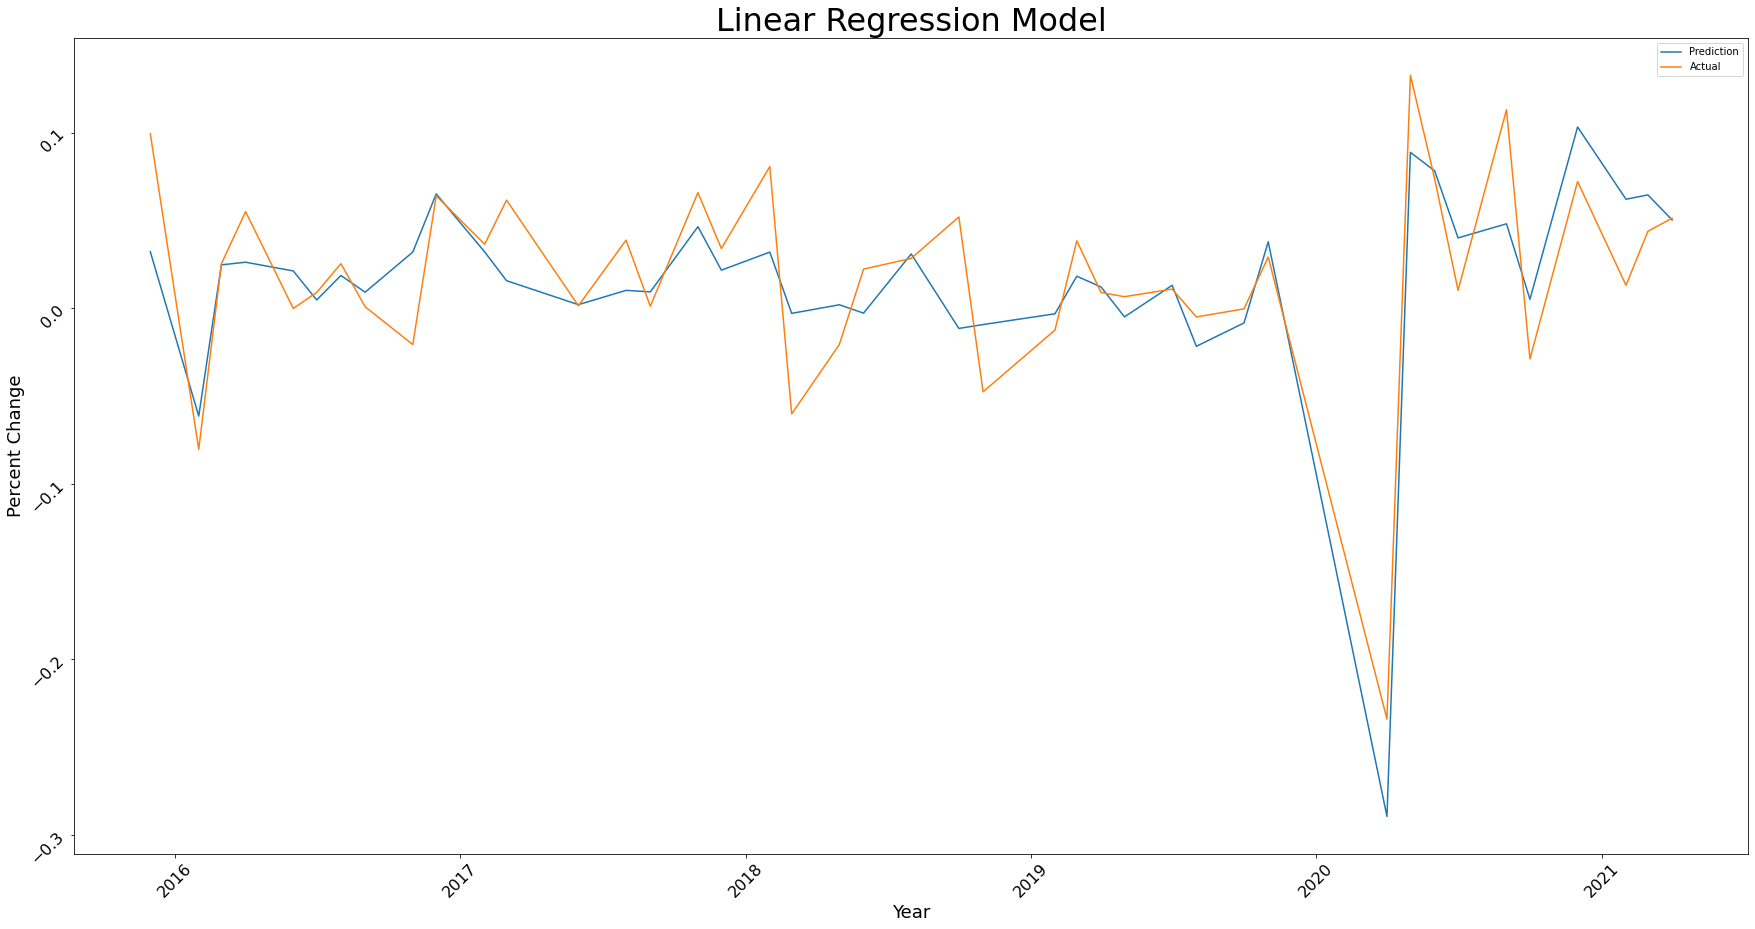

In [73]:
test = pd.DataFrame({"Prediction": list(predictions), "Actual": list(y_test.values)}).set_index(y_test.index)
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(15)
line1 = ax.plot(test['Prediction'], label="Prediction")
line2 = ax.plot(test['Actual'], label = 'Actual')
ax.set_ylabel('Percent Change', fontsize=18)
ax.set_xlabel('Year', fontsize=18)
ax.set_title('Linear Regression Model', fontsize=32)
#plt.plot(test)
plt.xticks(rotation = 45, fontsize=16)
plt.yticks(rotation = 45, fontsize=16)
#plt.style.use("Solarize_Light2")
plt.legend()
plt.savefig('Linear Regression Model.png')

### Linear Regression Feature Importance

Feature: 0, Score: 0.12371
Feature: 1, Score: -0.02132
Feature: 2, Score: -0.11050
Feature: 3, Score: 0.53462
Feature: 4, Score: 0.39338


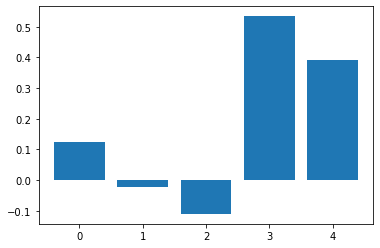

In [74]:
importance = regr.coef_.flatten()
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Decision Tree Regressor Model

### Fitting the data

In [75]:
# Fitting the decision tree
model = tree.DecisionTreeRegressor()
model = model.fit(X_train_scaled, y_train)

# Making predictions
predictions = model.predict(X_test_scaled)

### Coefficients

In [76]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, predictions))

Coefficients: 
 [[ 0.12371411 -0.02131856 -0.11050374  0.5346154   0.39337618]]
Mean squared error: 0.0025759430
Coefficient of determination: 0.25


### Plotting the data

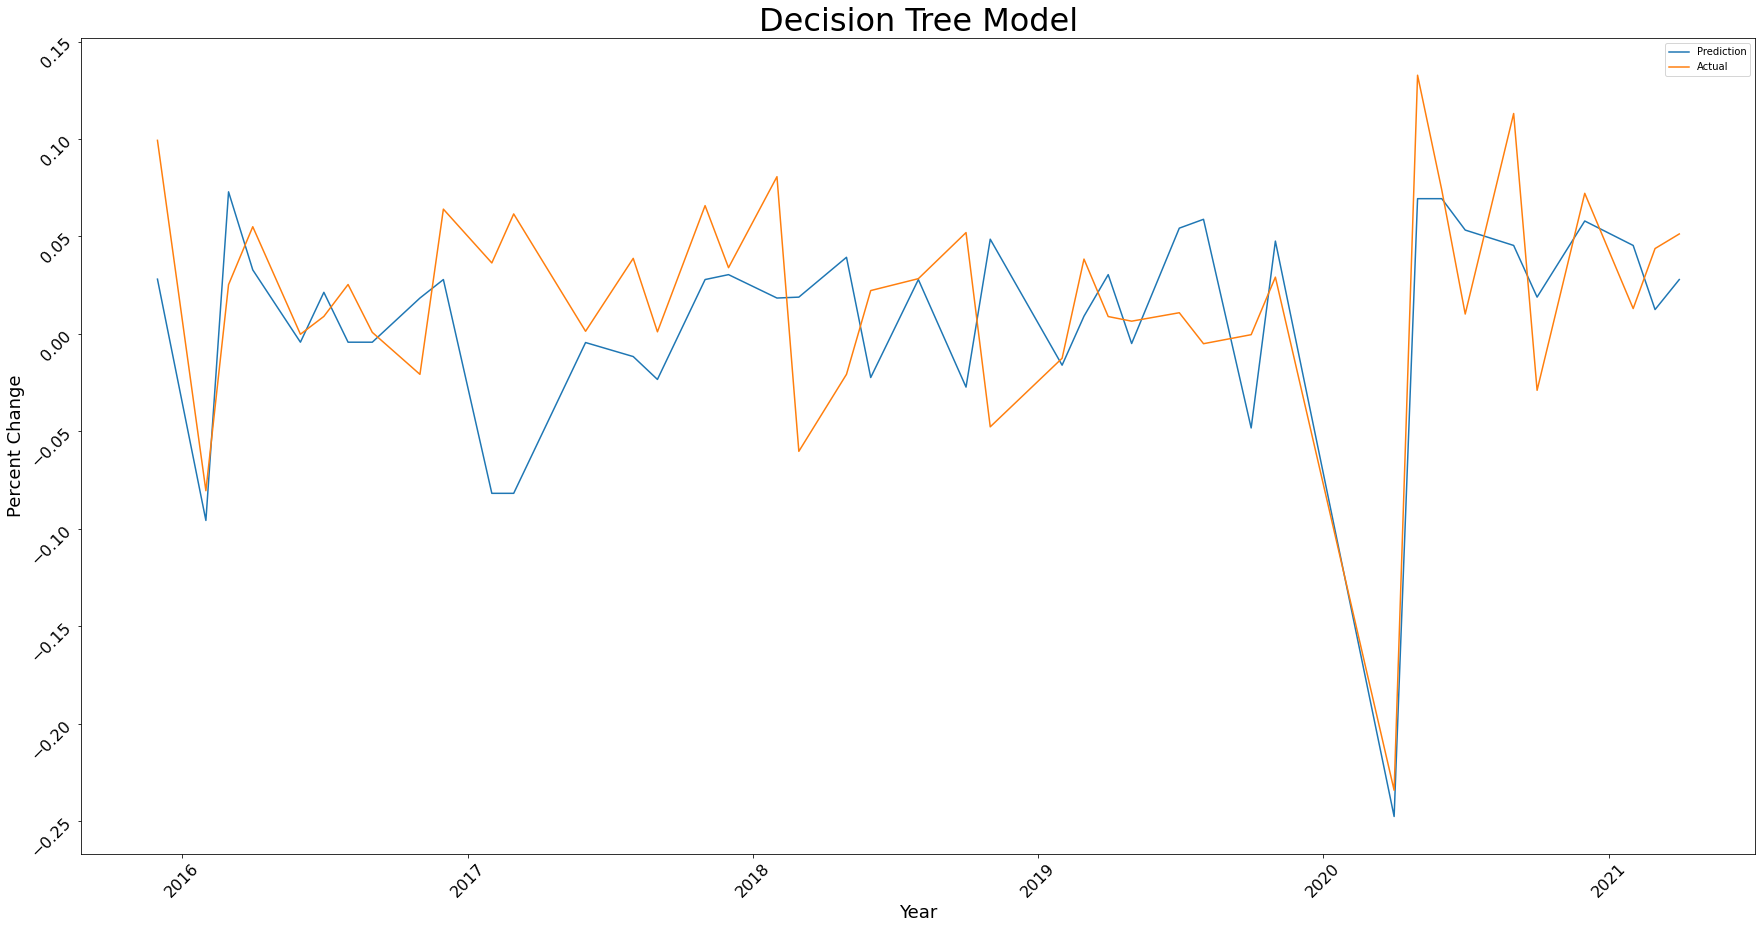

In [77]:
test_tree = pd.DataFrame({"Prediction": list(predictions), "Actual": list(y_test.values)}).set_index(y_test.index)
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(15)
line1 = ax.plot(test_tree['Prediction'], label="Prediction")
line2 = ax.plot(test_tree['Actual'], label = 'Actual')
ax.set_ylabel('Percent Change', fontsize=18)
ax.set_xlabel('Year', fontsize=18)
ax.set_title('Decision Tree Model', fontsize=32)
#plt.plot(test)
plt.xticks(rotation = 45, fontsize=16)
plt.yticks(rotation = 45, fontsize=16)
#plt.style.use("Solarize_Light2")
plt.legend()
plt.savefig('Decision Tree Model.png')

### Decision Tree Feature Importance

Feature: 0, Score: 0.21677
Feature: 1, Score: 0.05736
Feature: 2, Score: 0.09406
Feature: 3, Score: 0.56870
Feature: 4, Score: 0.06312


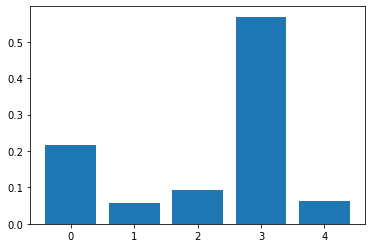

In [78]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# LGBM Regressor

### Fitting the data

In [79]:
lgbm = ltb.LGBMRegressor()
lgbm.fit(X_train_scaled, y_train.values.ravel())
print(); print(model)

predictions = model.predict(X_test_scaled)


DecisionTreeRegressor()


### Coefficients

In [80]:
print(f"R-squared: %.10f" % r2_score(y_test, predictions))
print(f"Mean Squared Error: %.10f" % mean_squared_error(y_test, predictions))

R-squared: 0.2461271269
Mean Squared Error: 0.0025759430


### Plotting the data

C:\Users\Sebs1\anaconda3\envs\dev\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Dow Value'>

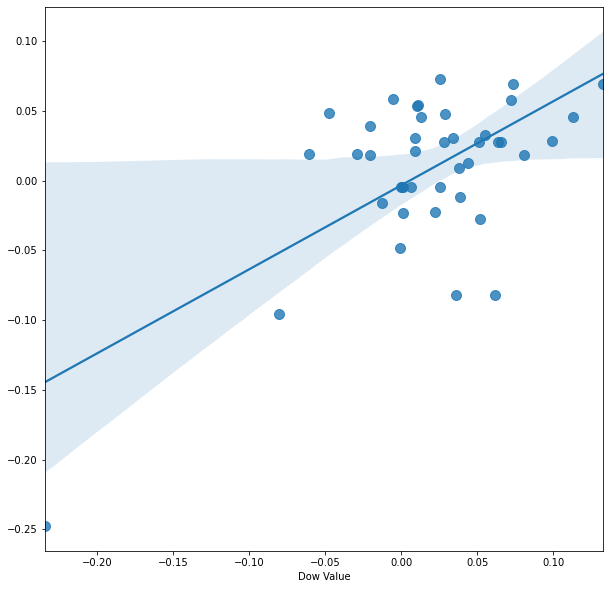

In [81]:
plt.figure(figsize=(10,10))
sns.regplot(y_test, predictions, fit_reg=True, scatter_kws={"s": 100},)

# SGD Regressor

### Fitting the data

In [83]:
sgdr = SGDRegressor()
sgdr.fit(X_train_scaled, y_train.values.ravel())
ypred = sgdr.predict(X_test_scaled)

### Coefficients

In [87]:
score = sgdr.score(X_train_scaled, y_train)
print("R-squared:", score)
cv_score = cross_val_score(sgdr, X_train_scaled, y_train.values.ravel(), cv = 10)
print("CV mean score: ", cv_score.mean())
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

R-squared: 0.5733223206907406
CV mean score:  0.44209667373152933
MSE:  0.0012835906364274158
RMSE:  0.0006417953182137079


### Plotting the data

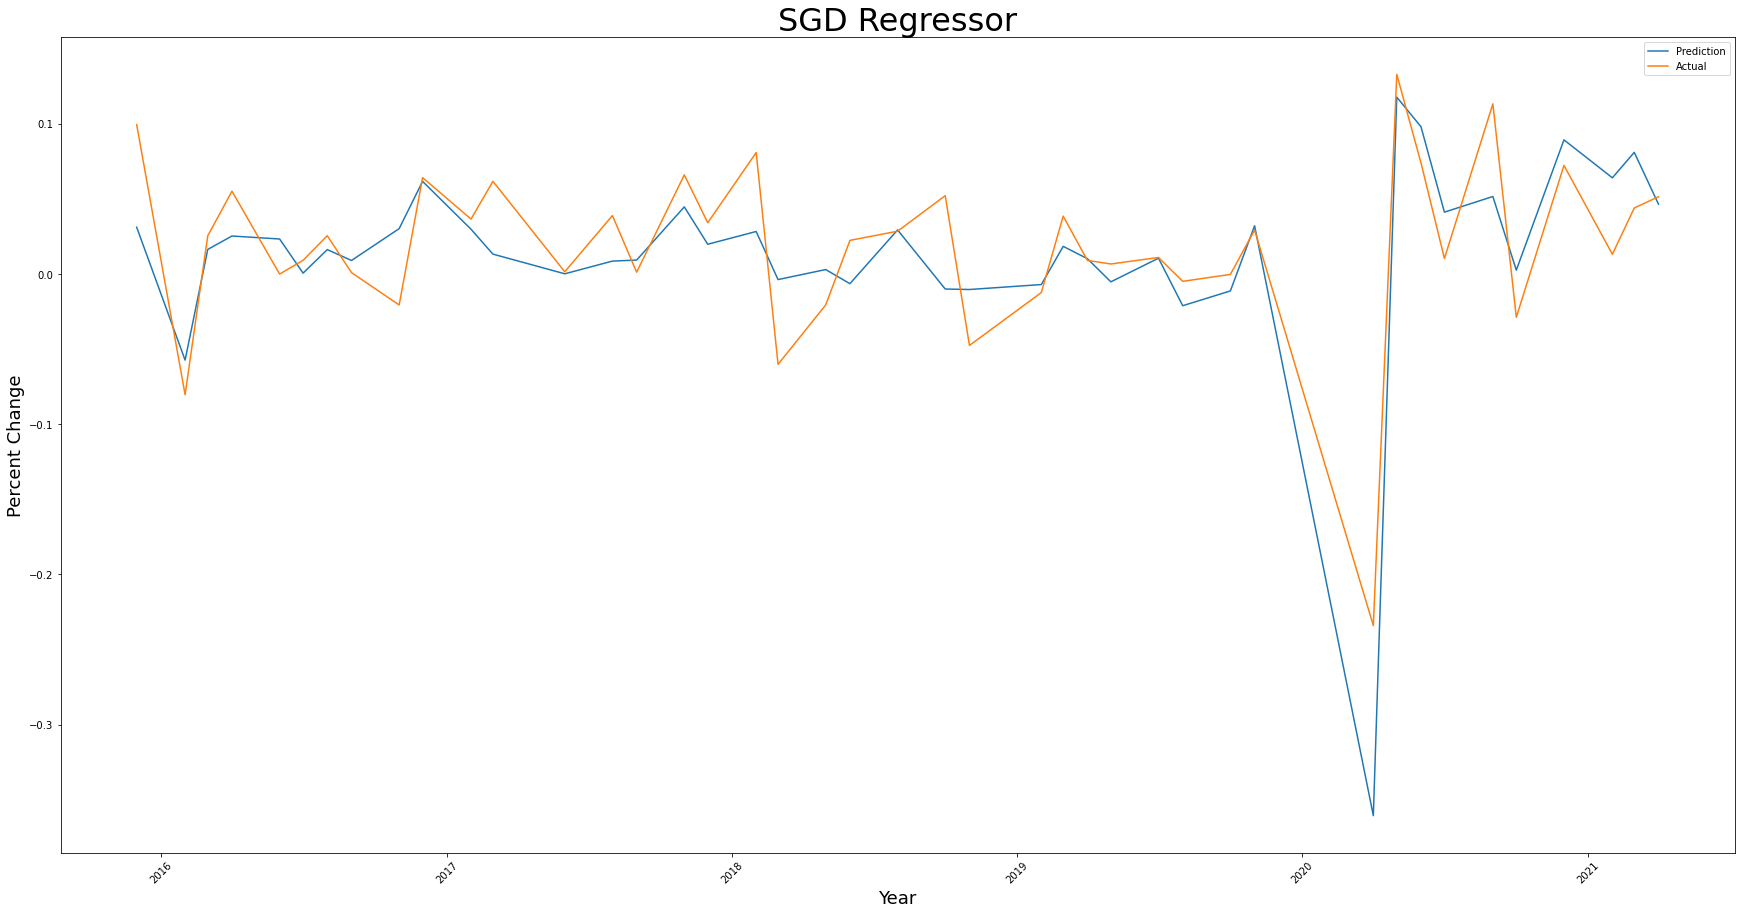

In [88]:
test = pd.DataFrame({"Prediction": list(ypred), "Actual": list(y_test.values)}).set_index(y_test.index)
x_ax = range(len(y_test))
fig, ax = plt.subplots()
fig.set_figwidth(30)
fig.set_figheight(15)
line1 = ax.plot(test['Prediction'], label="Prediction")
line2 = ax.plot(test['Actual'], label = 'Actual')
#plt.plot(test)
plt.xticks(rotation = 45)
ax.set_ylabel('Percent Change', fontsize=18)
ax.set_xlabel('Year', fontsize=18)
ax.set_title('SGD Regressor', fontsize=32)
plt.legend()
fig.savefig('SGD Regressor.png')

Feature: 0, Score: 0.01201
Feature: 1, Score: -0.00219
Feature: 2, Score: -0.01382
Feature: 3, Score: 0.02324
Feature: 4, Score: 0.00441


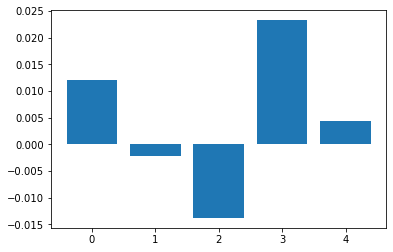

In [89]:
importance = sgdr.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()